## Data Imputation Techniques

Prof. Daniel de Abreu Pereira Uhr



### Data Imputation Techniques

As técnicas de imputação de dados são usadas para lidar com dados ausentes em conjuntos de dados. Existem várias abordagens, incluindo:
- **Média**: Substituir valores ausentes pela média dos valores disponíveis.
- **Mediana**: Usar a mediana dos valores disponíveis para substituir os ausentes
- **Moda**: Substituir valores ausentes pela moda (valor mais frequente) dos dados.
- **Interpolação**: Preencher valores ausentes com base em valores adjacentes, como interpolação linear ou polinomial.
- **KNN (K-Nearest Neighbors)**: Usar a média ou mediana dos k vizinhos mais próximos para preencher valores ausentes.
- **Regressão**: Usar modelos de regressão para prever valores ausentes com base em outras variáveis.

Aqui vamos utilizar as bibliotecas `fancyimpute`, `missforest`  e `pymc` para realizar a imputação de dados.

* `python -m pip install prophet`
* `python -m pip install pymc`
* 

***Carregando as bibliotecas necessárias:***

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from prophet import Prophet

#### Filtragem da base de dados


In [4]:
# Caminho com acento → usar raw string (r"...")
caminho = r"C:\Users\danie\OneDrive\Área de Trabalho\data_imputation\df_unico_completo_2000_ate_2023.xlsx"
# Lê a primeira planilha (ou especifique `sheet_name`)
df = pd.read_excel(caminho)

In [5]:
df

,ID,MUNICIPIOS,UF,ANO,ADM-GPS,ADM-DARF,ADM-TOTAL,PREV-GPS,PREV-DARF,PREV-TOTAL,...,GINI_MUNICIPIO_MUL_OUTROS,GINI_MUNICIPIO_MUL_PUBLICO,GINI_MUNICIPIO_MUL_SERVICOS,GINI_MUNICIPIO_HOM_AGRICULTURA,GINI_MUNICIPIO_HOM_COMERCIO,GINI_MUNICIPIO_HOM_CONSTRUCAO,GINI_MUNICIPIO_HOM_INDUSTRIA,GINI_MUNICIPIO_HOM_OUTROS,GINI_MUNICIPIO_HOM_PUBLICO,GINI_MUNICIPIO_HOM_SERVICOS
0,110001,ALTA FLORESTA D'OESTE,RO,2000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.195348,0.211490,0.364269,0.255295,0.238348,0.193139,0.216641,0.292589,0.258368,0.550412
1,110001,ALTA FLORESTA D'OESTE,RO,2001,NaN,NaN,NaN,NaN,NaN,NaN,...,0.267754,0.242606,0.421334,0.193050,0.272683,0.180466,0.214185,0.269549,0.284549,0.544207
2,110001,ALTA FLORESTA D'OESTE,RO,2002,NaN,NaN,NaN,NaN,NaN,NaN,...,0.284304,0.310983,0.393742,0.193430,0.280187,0.213855,0.207756,0.317279,0.438435,0.506939
3,110001,ALTA FLORESTA D'OESTE,RO,2003,NaN,NaN,NaN,NaN,NaN,NaN,...,0.231979,0.375381,0.343530,0.203021,0.258829,0.154678,0.205630,0.267884,0.468922,0.495185
4,110001,ALTA FLORESTA D'OESTE,RO,2004,NaN,NaN,NaN,NaN,NaN,NaN,...,0.335935,0.657694,0.358380,0.265840,0.344847,0.179238,0.210600,0.363493,0.623742,0.544957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133680,530010,BRASILIA,DF,2019,6.523869e+09,1.245627e+11,1.310865e+11,6.523869e+09,1.551714e+10,2.204101e+10,...,0.590160,0.403334,0.541912,0.312136,0.366367,0.379768,0.422684,0.633579,0.427143,0.564108
133681,530010,BRASILIA,DF,2020,6.274341e+09,1.163718e+11,1.226461e+11,6.274341e+09,1.560148e+10,2.187582e+10,...,0.606652,0.387311,0.565372,0.332140,0.388613,0.366516,0.450480,0.654845,0.506449,0.576834
133682,530010,BRASILIA,DF,2021,6.525144e+09,1.322172e+11,1.387423e+11,6.525144e+09,1.710378e+10,2.362892e+10,...,0.491059,0.398940,0.558855,0.307952,0.381305,0.378293,0.439376,0.545040,0.442426,0.569132
133683,530010,BRASILIA,DF,2022,3.541659e+09,1.563681e+11,1.599098e+11,3.541659e+09,2.320852e+10,2.675018e+10,...,0.546887,0.393405,0.711840,NaN,0.533093,0.540667,0.533023,0.610142,0.468475,0.727046


Existem colunas com "*Missing value*", com *strings* "*Não Disponível*" e *(*)*, e zeros "*0*" as quais representam valores ausentes. 

Vamos ajustar a base para que todos sejam tratados como "missing" e depois imputar os dados.


In [6]:
# Lista de colunas que NÃO devem ser convertidas
colunas_excluir = ['MUNICIPIOS', 'UF']

# Separa as colunas que serão convertidas
colunas_para_converter = df.columns.difference(colunas_excluir)

# Aplica a conversão somente às colunas selecionadas
df[colunas_para_converter] = df[colunas_para_converter].apply(lambda col: pd.to_numeric(col, errors='coerce'))

# Substitui zeros por NaN nas colunas numéricas (exceto MUNICIPIOS e UF)
df[colunas_para_converter] = df[colunas_para_converter].replace(0, np.nan)

# Verifica valores ausentes por coluna
print(df.isnull().sum())

ID                                   0
MUNICIPIOS                           5
UF                                  63
ANO                                  0
ADM-GPS                          28001
                                 ...  
GINI_MUNICIPIO_HOM_CONSTRUCAO    46063
GINI_MUNICIPIO_HOM_INDUSTRIA     25247
GINI_MUNICIPIO_HOM_OUTROS        50817
GINI_MUNICIPIO_HOM_PUBLICO        4215
GINI_MUNICIPIO_HOM_SERVICOS      12355
Length: 94, dtype: int64


In [7]:
df

,ID,MUNICIPIOS,UF,ANO,ADM-GPS,ADM-DARF,ADM-TOTAL,PREV-GPS,PREV-DARF,PREV-TOTAL,...,GINI_MUNICIPIO_MUL_OUTROS,GINI_MUNICIPIO_MUL_PUBLICO,GINI_MUNICIPIO_MUL_SERVICOS,GINI_MUNICIPIO_HOM_AGRICULTURA,GINI_MUNICIPIO_HOM_COMERCIO,GINI_MUNICIPIO_HOM_CONSTRUCAO,GINI_MUNICIPIO_HOM_INDUSTRIA,GINI_MUNICIPIO_HOM_OUTROS,GINI_MUNICIPIO_HOM_PUBLICO,GINI_MUNICIPIO_HOM_SERVICOS
0,110001,ALTA FLORESTA D'OESTE,RO,2000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.195348,0.211490,0.364269,0.255295,0.238348,0.193139,0.216641,0.292589,0.258368,0.550412
1,110001,ALTA FLORESTA D'OESTE,RO,2001,NaN,NaN,NaN,NaN,NaN,NaN,...,0.267754,0.242606,0.421334,0.193050,0.272683,0.180466,0.214185,0.269549,0.284549,0.544207
2,110001,ALTA FLORESTA D'OESTE,RO,2002,NaN,NaN,NaN,NaN,NaN,NaN,...,0.284304,0.310983,0.393742,0.193430,0.280187,0.213855,0.207756,0.317279,0.438435,0.506939
3,110001,ALTA FLORESTA D'OESTE,RO,2003,NaN,NaN,NaN,NaN,NaN,NaN,...,0.231979,0.375381,0.343530,0.203021,0.258829,0.154678,0.205630,0.267884,0.468922,0.495185
4,110001,ALTA FLORESTA D'OESTE,RO,2004,NaN,NaN,NaN,NaN,NaN,NaN,...,0.335935,0.657694,0.358380,0.265840,0.344847,0.179238,0.210600,0.363493,0.623742,0.544957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133680,530010,BRASILIA,DF,2019,6.523869e+09,1.245627e+11,1.310865e+11,6.523869e+09,1.551714e+10,2.204101e+10,...,0.590160,0.403334,0.541912,0.312136,0.366367,0.379768,0.422684,0.633579,0.427143,0.564108
133681,530010,BRASILIA,DF,2020,6.274341e+09,1.163718e+11,1.226461e+11,6.274341e+09,1.560148e+10,2.187582e+10,...,0.606652,0.387311,0.565372,0.332140,0.388613,0.366516,0.450480,0.654845,0.506449,0.576834
133682,530010,BRASILIA,DF,2021,6.525144e+09,1.322172e+11,1.387423e+11,6.525144e+09,1.710378e+10,2.362892e+10,...,0.491059,0.398940,0.558855,0.307952,0.381305,0.378293,0.439376,0.545040,0.442426,0.569132
133683,530010,BRASILIA,DF,2022,3.541659e+09,1.563681e+11,1.599098e+11,3.541659e+09,2.320852e+10,2.675018e+10,...,0.546887,0.393405,0.711840,NaN,0.533093,0.540667,0.533023,0.610142,0.468475,0.727046


In [8]:
df.columns

Index(['ID', 'MUNICIPIOS', 'UF', 'ANO', 'ADM-GPS', 'ADM-DARF', 'ADM-TOTAL',
       'PREV-GPS', 'PREV-DARF', 'PREV-TOTAL', 'IR ARRECADACAO PF',
       'IR QTD CONTRIBUINTES PF', 'IR ARRECADACAO PJ',
       'IR QTD CONTRIBUINTES PJ', 'ARRECADACAO IR-TOTAL',
       'QTD CONTRIBUINTES IR-TOTAL (PF E PJ)', 'IPI ARRECADACAO',
       'IPI QTD CONTRIBUINTES PJ', 'ITR', 'ICMS', 'ISS', 'INSS', 'ANALFABETO',
       'PRIMARIO_INCOMPL', 'FUNDAMENTAL', 'MEDIO_INCOMPL', 'MEDIO',
       'SUPERIOR_INCOMPL', 'SUPERIOR', 'IGNORADO', 'ANALFABETO_MUL',
       'PRIMARIO_INCOMPL_MUL', 'FUNDAMENTAL_MUL', 'MEDIO_INCOMPL_MUL',
       'MEDIO_MUL', 'SUPERIOR_INCOMPL_MUL', 'SUPERIOR_MUL', 'IGNORADO_MUL',
       'ANALFABETO_HOM', 'PRIMARIO_INCOMPL_HOM', 'FUNDAMENTAL_HOM',
       'MEDIO_INCOMPL_HOM', 'MEDIO_HOM', 'SUPERIOR_INCOMPL_HOM',
       'SUPERIOR_HOM', 'IGNORADO_HOM', 'REMUNERACAO_MEDIA', 'GINI_MUNICIPIO',
       'REMUNERACAO_MEDIA_MUL', 'REMUNERACAO_MEDIA_HOM', 'GINI_MUNICIPIO_MUL',
       'GINI_MUNICIPIO_HO

#### Prophet

Vamos criar uma rotina para gerar valores definidos por previsão de séries temporais, vou utilizar o "prophet" da Meta (Facebook). A ideia é que para cada variável, para cada município, se gere uma série temporal, e a partir dessa série temporal, gerar valores. Esses valores serão utilizados para imputar os dados faltantes.

* https://github.com/facebook/prophet
* https://github.com/facebook/prophet/tree/main/python

O Prophet é uma biblioteca de previsão de séries temporais desenvolvida pelo Facebook (*Prophet: Automatic Forecasting Procedure*). É projetada para lidar com dados que apresentam sazonalidade e tendências, tornando-a útil para prever valores futuros com base em dados históricos.

Vamos utilizar as colunas: 'ID', e ano 'ANO' para identificar o município no tempo. E começamos com a previsão de 'ADM-GPS'.

In [88]:
def imputar_com_prophet(df, id_municipio, varname="ADM-GPS"):
    """
    Imputa valores ausentes para um município específico em painel longo,
    mesmo que haja anos faltantes, usando Prophet com log1p e suavização.
    """
    # Define todos os anos a serem imputados
    anos_completos = pd.date_range(start="2000-01-01", end="2023-01-01", freq="YS")

    # Filtra o município e garante que todos os anos estejam no DataFrame
    df_mun = df[df["ID"] == id_municipio][["ANO", varname]].copy()
    df_mun["ds"] = pd.to_datetime(df_mun["ANO"].astype(str) + "-01-01")

    # Cria base com todos os anos, mesmo que ausentes
    df_base = pd.DataFrame({"ds": anos_completos})
    df_merge = pd.merge(df_base, df_mun[["ds", varname]], on="ds", how="left")
    
    df_merge["ID"] = id_municipio

    # Define observados para treinar
    df_obs = df_merge.dropna(subset=[varname]).copy()
    if len(df_obs) < 3:
        return None

    df_obs = df_obs.rename(columns={varname: "y"})
    df_obs["y"] = np.log1p(df_obs["y"])

    try:
        model = Prophet(
            yearly_seasonality=True,
            changepoint_prior_scale=0.5,
            n_changepoints=20
        )
        model.fit(df_obs)

        forecast = model.predict(df_base)
        df_merge["yhat"] = np.expm1(forecast["yhat"]).clip(lower=0)

        return df_merge[["ID", "ds", varname, "yhat"]]

    except Exception as e:
        print(f"Erro ao imputar município {id_municipio}: {e}")
        return None


def imputar_todos_municipios(df, varname="ADM-GPS", n="all"):
    """
    Roda a imputação com Prophet para n municípios (ou todos, se n='all').
    """
    resultados = []
    ids_municipios = df["ID"].dropna().unique()
    if isinstance(n, int):
        ids_municipios = ids_municipios[:n]

    for id_mun in tqdm(ids_municipios, desc=f"Imputando {n if isinstance(n, int) else 'todos'} municípios"):
        res = imputar_com_prophet(df, id_mun, varname)
        if res is not None:
            resultados.append(res)

    if resultados:
        return pd.concat(resultados, ignore_index=True)
    else:
        return pd.DataFrame()


def plot_prophet_imputation(df_resultado, id_municipio, varname="ADM-GPS"):
    """
    Plota série observada e imputada para um município.
    """
    df_plot = df_resultado[df_resultado["ID"] == id_municipio]
    plt.figure(figsize=(12, 6))
    plt.plot(df_plot["ds"], df_plot["yhat"], label="Imputado (Prophet)", linestyle="--", color="blue")
    plt.plot(df_plot["ds"], df_plot[varname], label="Observado", marker="o", color="black")
    plt.title(f"{varname} - Município {id_municipio}")
    plt.xlabel("Ano")
    plt.ylabel(varname)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [89]:
# Roda para os 10 primeiros municípios
df_imputado_teste = imputar_todos_municipios(df, varname="ADM-GPS", n=10)

Imputando 10 municípios:   0%|          | 0/10 [00:00<?, ?it/s]10:38:18 - cmdstanpy - INFO - Chain [1] start processing
10:38:19 - cmdstanpy - INFO - Chain [1] done processing
Imputando 10 municípios:  10%|█         | 1/10 [00:00<00:03,  2.53it/s]10:38:19 - cmdstanpy - INFO - Chain [1] start processing
10:38:19 - cmdstanpy - INFO - Chain [1] done processing
Imputando 10 municípios:  20%|██        | 2/10 [00:00<00:02,  2.90it/s]10:38:19 - cmdstanpy - INFO - Chain [1] start processing
10:38:19 - cmdstanpy - INFO - Chain [1] done processing
Imputando 10 municípios:  30%|███       | 3/10 [00:01<00:02,  2.84it/s]10:38:19 - cmdstanpy - INFO - Chain [1] start processing
10:38:20 - cmdstanpy - INFO - Chain [1] done processing
Imputando 10 municípios:  40%|████      | 4/10 [00:01<00:02,  2.75it/s]10:38:20 - cmdstanpy - INFO - Chain [1] start processing
10:38:20 - cmdstanpy - INFO - Chain [1] done processing
Imputando 10 municípios:  50%|█████     | 5/10 [00:01<00:01,  2.94it/s]10:38:20 - cmdsta

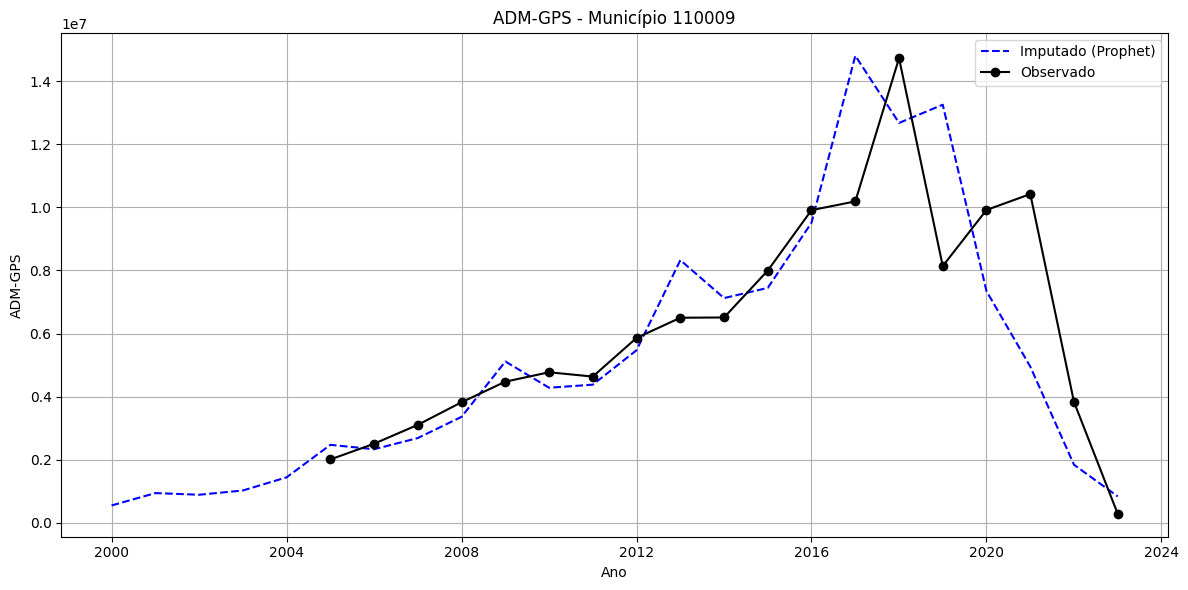

In [99]:
# Visualiza qualquer município com dados imputados
plot_prophet_imputation(df_imputado_teste, id_municipio=110009, varname="ADM-GPS")

Deu certo, agora vamos rodar para todos os municípios e sobreescrever a coluna 'ADM-GPS' com os valores imputados.

In [101]:
# Roda para todos os municípios
df_imputado_teste = imputar_todos_municipios(df, varname="ADM-GPS", n="all")

Imputando todos municípios:   0%|          | 0/5571 [00:00<?, ?it/s]11:50:47 - cmdstanpy - INFO - Chain [1] start processing
11:50:47 - cmdstanpy - INFO - Chain [1] done processing
Imputando todos municípios:   0%|          | 1/5571 [00:00<36:12,  2.56it/s]11:50:47 - cmdstanpy - INFO - Chain [1] start processing
11:50:48 - cmdstanpy - INFO - Chain [1] done processing
Imputando todos municípios:   0%|          | 2/5571 [00:00<30:31,  3.04it/s]11:50:48 - cmdstanpy - INFO - Chain [1] start processing
11:50:48 - cmdstanpy - INFO - Chain [1] done processing
Imputando todos municípios:   0%|          | 3/5571 [00:00<25:42,  3.61it/s]11:50:48 - cmdstanpy - INFO - Chain [1] start processing
11:50:48 - cmdstanpy - INFO - Chain [1] done processing
Imputando todos municípios:   0%|          | 4/5571 [00:01<26:16,  3.53it/s]11:50:48 - cmdstanpy - INFO - Chain [1] start processing
11:50:48 - cmdstanpy - INFO - Chain [1] done processing
Imputando todos municípios:   0%|          | 5/5571 [00:01<24:2

In [104]:
# 1. Resultado da imputação (já foi criado)
df_resultado = df_imputado_teste          # ou use df_imputado_teste direto

# 2. Adiciona coluna ANO
df_resultado["ANO"] = df_resultado["ds"].dt.year

# 3. Copia do painel original (opcional)
df_full = df.copy()

# 4. Seleciona previsões e faz o merge
prev = df_resultado[["ID", "ANO", "yhat"]]

df_full = (
    df_full
    .merge(prev, on=["ID", "ANO"], how="left")
    .assign(**{
        "ADM-GPS_filled": lambda d: d["ADM-GPS"].combine_first(d["yhat"])
    })
    .drop(columns=["yhat"])
)

# Agora df_full["ADM-GPS_filled"] tem:
#   • valor observado (ADM-GPS) quando existe
#   • senão, a previsão gerada (yhat)


In [105]:
df_full

,ID,MUNICIPIOS,UF,ANO,ADM-GPS,ADM-DARF,ADM-TOTAL,PREV-GPS,PREV-DARF,PREV-TOTAL,...,GINI_MUNICIPIO_MUL_PUBLICO,GINI_MUNICIPIO_MUL_SERVICOS,GINI_MUNICIPIO_HOM_AGRICULTURA,GINI_MUNICIPIO_HOM_COMERCIO,GINI_MUNICIPIO_HOM_CONSTRUCAO,GINI_MUNICIPIO_HOM_INDUSTRIA,GINI_MUNICIPIO_HOM_OUTROS,GINI_MUNICIPIO_HOM_PUBLICO,GINI_MUNICIPIO_HOM_SERVICOS,ADM-GPS_filled
0,110001,ALTA FLORESTA D'OESTE,RO,2000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.211490,0.364269,0.255295,0.238348,0.193139,0.216641,0.292589,0.258368,0.550412,1.418339e+06
1,110001,ALTA FLORESTA D'OESTE,RO,2001,NaN,NaN,NaN,NaN,NaN,NaN,...,0.242606,0.421334,0.193050,0.272683,0.180466,0.214185,0.269549,0.284549,0.544207,2.216964e+06
2,110001,ALTA FLORESTA D'OESTE,RO,2002,NaN,NaN,NaN,NaN,NaN,NaN,...,0.310983,0.393742,0.193430,0.280187,0.213855,0.207756,0.317279,0.438435,0.506939,1.942882e+06
3,110001,ALTA FLORESTA D'OESTE,RO,2003,NaN,NaN,NaN,NaN,NaN,NaN,...,0.375381,0.343530,0.203021,0.258829,0.154678,0.205630,0.267884,0.468922,0.495185,2.019654e+06
4,110001,ALTA FLORESTA D'OESTE,RO,2004,NaN,NaN,NaN,NaN,NaN,NaN,...,0.657694,0.358380,0.265840,0.344847,0.179238,0.210600,0.363493,0.623742,0.544957,2.490826e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133702,530010,BRASILIA,DF,2019,6.523869e+09,1.245627e+11,1.310865e+11,6.523869e+09,1.551714e+10,2.204101e+10,...,0.403334,0.541912,0.312136,0.366367,0.379768,0.422684,0.633579,0.427143,0.564108,6.523869e+09
133703,530010,BRASILIA,DF,2020,6.274341e+09,1.163718e+11,1.226461e+11,6.274341e+09,1.560148e+10,2.187582e+10,...,0.387311,0.565372,0.332140,0.388613,0.366516,0.450480,0.654845,0.506449,0.576834,6.274341e+09
133704,530010,BRASILIA,DF,2021,6.525144e+09,1.322172e+11,1.387423e+11,6.525144e+09,1.710378e+10,2.362892e+10,...,0.398940,0.558855,0.307952,0.381305,0.378293,0.439376,0.545040,0.442426,0.569132,6.525144e+09
133705,530010,BRASILIA,DF,2022,3.541659e+09,1.563681e+11,1.599098e+11,3.541659e+09,2.320852e+10,2.675018e+10,...,0.393405,0.711840,NaN,0.533093,0.540667,0.533023,0.610142,0.468475,0.727046,3.541659e+09


#### Interpolação

In [9]:
import pandas as pd

# Cria uma cópia da base original
df_interp = df.copy()

# Ordena o DataFrame por ID e ANO (importante para interpolação)
df_interp.sort_values(by=["ID", "ANO"], inplace=True)

# Lista de todos os municípios
municipios = df_interp["ID"].unique()

# Loop por município
for mun in municipios:
    # Máscara para o município atual
    mask = df_interp["ID"] == mun
    
    # Extrai a série temporal de ADM-GPS
    serie = df_interp.loc[mask, "ADM-GPS"]
    
    # Interpola ao longo do tempo
    serie_interp = serie.interpolate(method="linear", limit_direction="both")
    
    # Atualiza a base imputada
    df_interp.loc[mask, "ADM-GPS"] = serie_interp


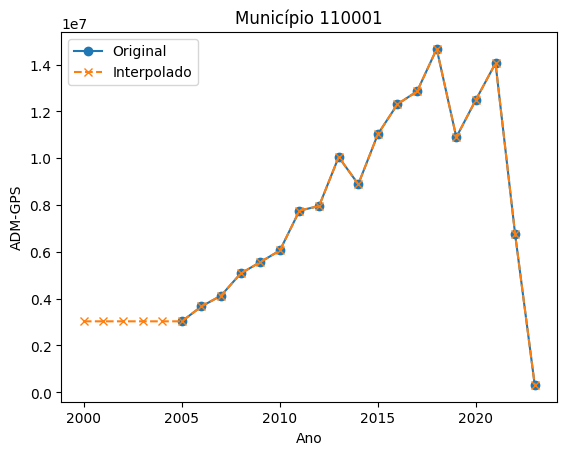

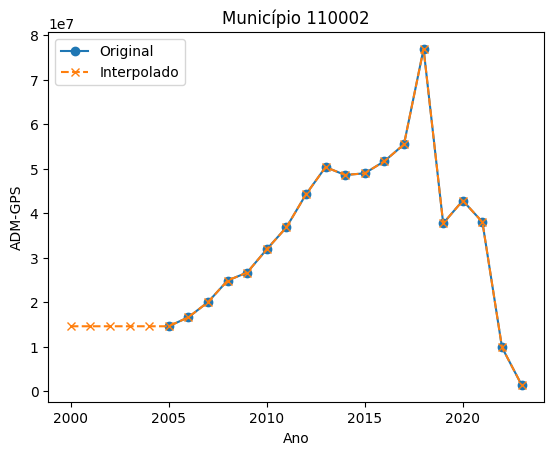

In [ ]:
for mun in [municipios[0], municipios[1]]:
    sub = df[df["ID"] == mun]
    sub_interp = df_interp[df_interp["ID"] == mun]
    
    plt.plot(sub["ANO"], sub["ADM-GPS"], 'o-', label='Original')
    plt.plot(sub_interp["ANO"], sub_interp["ADM-GPS"], 'x--', label='Interpolado')
    plt.title(f"Município {mun}")
    plt.xlabel("Ano")
    plt.ylabel("ADM-GPS")
    plt.legend()
    plt.show()


#### Interative Imputer

In [33]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Seleciona apenas colunas numéricas
df_iter = df.select_dtypes(include=["number"]).copy()

# Verifica se ID e ANO estão completos
assert df_iter["ID"].isnull().sum() == 0
assert df_iter["ANO"].isnull().sum() == 0

# Define o modelo base para imputação
modelo_rf = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1)

# Cria o imputador com o modelo escolhido
imputador = IterativeImputer(estimator=modelo_rf, max_iter=10, random_state=42)

# Aplica a imputação
dados_imputados = imputador.fit_transform(df_iter)

# Reconstrói o DataFrame
df_imputado = pd.DataFrame(dados_imputados, columns=df_iter.columns, index=df_iter.index)

# Confirma que não há mais NaNs
print("Valores faltantes após imputação:", df_imputado.isnull().sum().sum())


c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: [27 35 43]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


KeyboardInterrupt: 